In [ ]:
import cv2
import numpy as np
from osgeo import gdal

def remove_black_borders(input_path, output_path):
    # Load the georeferenced image
    dataset = gdal.Open(input_path)
    band = dataset.GetRasterBand(1)  # Read first band
    image = band.ReadAsArray()

    # Convert to 8-bit (normalize values if needed)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Convert grayscale to binary mask (black pixels -> mask)
    _, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

    # Find contours of non-black areas
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding box of the largest contour
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_image = image[y:y+h, x:x+w]

        # Crop georeferencing
        gt = dataset.GetGeoTransform()
        new_gt = (gt[0] + x * gt[1], gt[1], gt[2], gt[3] + y * gt[5], gt[4], gt[5])

        # Save the cropped image with updated georeferencing
        driver = gdal.GetDriverByName("GTiff")
        out_dataset = driver.Create(output_path, w, h, 1, gdal.GDT_Byte)
        out_dataset.SetGeoTransform(new_gt)
        out_dataset.SetProjection(dataset.GetProjection())
        out_band = out_dataset.GetRasterBand(1)
        out_band.WriteArray(cropped_image)

        # Cleanup
        out_dataset.FlushCache()
        print("Black borders removed and image saved:", output_path)

    else:
        print("No black borders detected.")

# Example usage
remove_black_borders("/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/DJI_20240614145135_0012_HA-waypoint4-80m_rtk_georef.tif", "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output.tif")


Black borders removed and image saved: /content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output.tif


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from osgeo import gdal, gdal_array

def remove_black_to_transparent(input_path, output_path):
    # Load the georeferenced image
    dataset = gdal.Open(input_path)
    if dataset is None:
        print("Error: Unable to open file. Check path and format.")
        return

    # Read the image as an array (assuming RGB or grayscale)
    image = dataset.ReadAsArray()

    # If single-band, convert to 3-channel grayscale
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)

    # Convert to 8-bit (if needed)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Create an alpha channel (fully opaque by default)
    alpha = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8) * 255

    # Identify black pixels (thresholding)
    mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)
    alpha[mask] = 0  # Set black pixels as transparent

    # Combine RGB + Alpha
    image_rgba = np.dstack([image, alpha])

    # Save as a 4-band (RGBA) GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, image.shape[1], image.shape[0], 4, gdal.GDT_Byte)

    if out_dataset is None:
        print("Error: Unable to create output file.")
        return

    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    out_dataset.SetProjection(dataset.GetProjection())

    # Write each band (R, G, B, Alpha)
    for i in range(4):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(image_rgba[:, :, i])

    out_dataset.FlushCache()
    print("Black areas converted to transparency. Saved as:", output_path)

# Example usage
remove_black_to_transparent(
    "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/DJI_20240614145135_0012_HA-waypoint4-80m_rtk_georef.tif",
    "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent.tif"
)


Black areas converted to transparency. Saved as: /content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent.tif


In [ ]:
import cv2
import numpy as np
from osgeo import gdal

def remove_black_to_transparent(input_path, output_path, threshold=15):
    # Load the georeferenced image
    dataset = gdal.Open(input_path)
    if dataset is None:
        print("❌ Error: Unable to open file. Check path and format.")
        return

    # Read image as array
    image = dataset.ReadAsArray()
    print("✅ Image loaded. Shape:", image.shape)

    # If grayscale, convert to RGB (expand channels)
    if len(image.shape) == 2:
        print("⚠️ Grayscale detected, converting to RGB.")
        image = np.stack([image] * 3, axis=-1)

    # If multi-band (4+ bands), extract first 3 bands (RGB)
    elif len(image.shape) == 3 and image.shape[0] > 3:
        print("⚠️ Multi-band image detected. Using first 3 bands (RGB).")
        image = image[:3, :, :]

    # Convert to 8-bit
    image = np.transpose(image, (1, 2, 0))  # Rearrange bands
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Create alpha channel (fully opaque by default)
    alpha = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8) * 255

    # Detect "almost black" pixels (dark areas)
    mask = (image[:, :, 0] < threshold) & (image[:, :, 1] < threshold) & (image[:, :, 2] < threshold)
    print(f"🔍 {np.sum(mask)} pixels detected as black.")

    # Debug: Show the mask before applying it
    cv2.imwrite("debug_mask.png", (mask.astype(np.uint8) * 255))

    alpha[mask] = 0  # Make them transparent

    # Stack RGB + Alpha
    image_rgba = np.dstack([image, alpha])
    print("✅ RGBA image created.")

    # Save as GeoTIFF with 4 bands (RGBA)
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, image.shape[1], image.shape[0], 4, gdal.GDT_Byte)

    if out_dataset is None:
        print("❌ Error: Unable to create output file.")
        return

    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    out_dataset.SetProjection(dataset.GetProjection())

    # Write each band (R, G, B, Alpha)
    for i in range(4):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(image_rgba[:, :, i])

    out_dataset.FlushCache()
    print("✅ Black areas converted to transparency. Saved:", output_path)

# Example usage
remove_black_to_transparent("rotated_output91.tif", "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent91.tif")


✅ Image loaded. Shape: (3, 8824, 9824)
🔍 41951030 pixels detected as black.
✅ RGBA image created.
✅ Black areas converted to transparency. Saved: /content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent91.tif


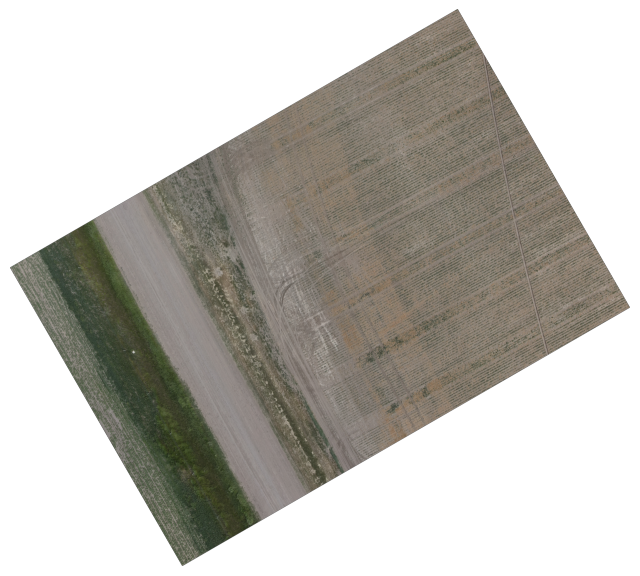

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

def display_tiff(image_path):
    dataset = gdal.Open(image_path)

    if dataset is None:
        print("Error: Unable to open file.")
        return

    # Read as numpy array
    image = dataset.ReadAsArray()

    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    else:
        image = np.transpose(image, (1, 2, 0))  # Rearrange bands for correct display

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
display_tiff("/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent91.tif")


In [ ]:
from google.colab import files
files.download("/content/output_transparent2.tif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from osgeo import gdal

def rotate_tiff(input_path, output_path, angle):
    # Load the georeferenced image
    dataset = gdal.Open(input_path)
    if dataset is None:
        print("❌ Error: Unable to open file. Check path and format.")
        return

    # Read image as array
    image = dataset.ReadAsArray()

    # If grayscale, expand to 3 channels
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)

    # If multi-band (4+ bands), extract first 3 bands (RGB)
    elif len(image.shape) == 3 and image.shape[0] > 3:
        image = image[:3, :, :]

    # Convert to 8-bit and rearrange dimensions
    image = np.transpose(image, (1, 2, 0))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Get image dimensions
    h, w = image.shape[:2]

    # Compute rotation matrix
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute new bounding dimensions after rotation
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix to consider translation
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Rotate the image without cropping
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderValue=(0, 0, 0))

    # Preserve georeferencing
    gt = dataset.GetGeoTransform()
    new_gt = (
        gt[0] - ((new_w - w) / 2) * gt[1],  # Adjust origin X
        gt[1], gt[2],
        gt[3] - ((new_h - h) / 2) * gt[5],  # Adjust origin Y
        gt[4], gt[5]
    )

    # Save rotated image as GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, new_w, new_h, 3, gdal.GDT_Byte)

    if out_dataset is None:
        print("❌ Error: Unable to create output file.")
        return

    out_dataset.SetGeoTransform(new_gt)
    out_dataset.SetProjection(dataset.GetProjection())

    for i in range(3):  # Write RGB bands
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(rotated_image[:, :, i])

    out_dataset.FlushCache()
    print("✅ Rotated image saved:", output_path)

# Example usage
rotate_tiff("/content/drive/MyDrive/DJI_DroneData/sample_overlap/DJI_20240614150133_0091_HA-waypoint18-80m_georef.tif", "rotated_output91.tif", 30)  # Rotate by 30 degrees


✅ Rotated image saved: rotated_output91.tif


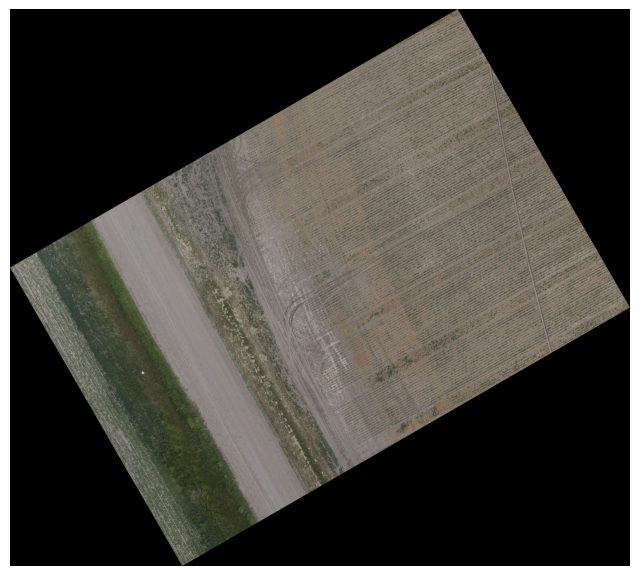

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

def display_tiff(image_path):
    dataset = gdal.Open(image_path)

    if dataset is None:
        print("Error: Unable to open file.")
        return

    # Read as numpy array
    image = dataset.ReadAsArray()

    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    else:
        image = np.transpose(image, (1, 2, 0))  # Rearrange bands for correct display

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
display_tiff("rotated_output90.tif")


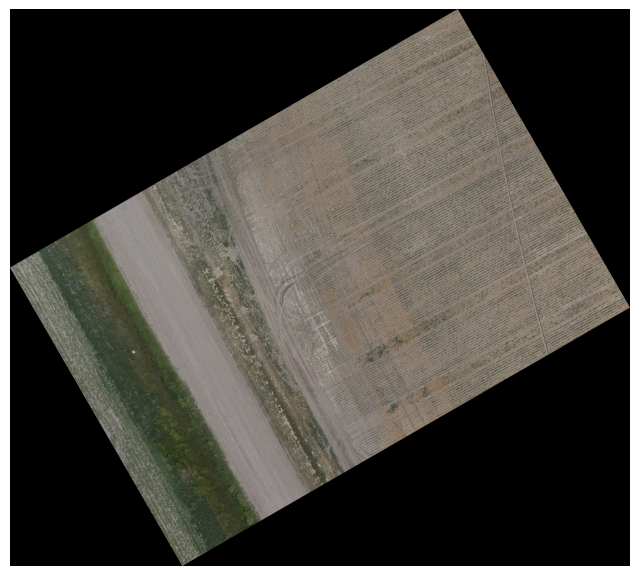

In [ ]:
display_tiff("rotated_output91.tif")

In [ ]:
import numpy as np
from osgeo import gdal, gdal_array

def stitch_tiff(image1_path, image2_path, output_path):
    # Open both images
    dataset1 = gdal.Open(image1_path)
    dataset2 = gdal.Open(image2_path)

    if dataset1 is None or dataset2 is None:
        print("❌ Error: Unable to open input files.")
        return

    # Read images as arrays
    img1 = dataset1.ReadAsArray()
    img2 = dataset2.ReadAsArray()

    # Ensure both images have the same number of channels
    def ensure_rgba(image):
        """ Convert image to RGBA if needed """
        if len(image.shape) == 2:  # Grayscale -> Expand to 3 channels (RGB)
            image = np.stack([image] * 3, axis=0)
        if image.shape[0] == 3:  # RGB -> Convert to RGBA by adding an alpha channel
            alpha_channel = np.ones((1, image.shape[1], image.shape[2]), dtype=np.uint8) * 255
            image = np.vstack([image, alpha_channel])
        return image

    img1 = ensure_rgba(img1)
    img2 = ensure_rgba(img2)

    # Get geotransforms and projections
    gt1, proj1 = dataset1.GetGeoTransform(), dataset1.GetProjection()
    gt2, proj2 = dataset2.GetGeoTransform(), dataset2.GetProjection()

    if proj1 != proj2:
        print("⚠ Warning: Different projections detected! Consider reprojecting before merging.")

    # Calculate the boundaries of both images
    x_min = min(gt1[0], gt2[0])
    x_max = max(gt1[0] + dataset1.RasterXSize * gt1[1], gt2[0] + dataset2.RasterXSize * gt2[1])
    y_min = min(gt1[3] + dataset1.RasterYSize * gt1[5], gt2[3] + dataset2.RasterYSize * gt2[5])
    y_max = max(gt1[3], gt2[3])

    # Compute output dimensions
    pixel_size = gt1[1]  # Assuming both have the same pixel size
    width = int((x_max - x_min) / pixel_size)
    height = int((y_max - y_min) / abs(gt1[5]))

    # Create an empty array for the stitched image
    stitched_image = np.zeros((4, height, width), dtype=np.uint8)  # 4 channels (RGBA)

    def paste_image(image, dataset, gt):
        """ Paste image data into the stitched canvas based on geolocation. """
        x_offset = int((gt[0] - x_min) / pixel_size)
        y_offset = int((y_max - gt[3]) / abs(gt1[5]))
        stitched_image[:, y_offset:y_offset + dataset.RasterYSize, x_offset:x_offset + dataset.RasterXSize] = image

    # Paste both images into the stitched canvas
    paste_image(img1, dataset1, gt1)
    paste_image(img2, dataset2, gt2)

    # Save the stitched image as a new GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, width, height, 4, gdal.GDT_Byte)
    out_dataset.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    out_dataset.SetProjection(proj1)

    for band in range(4):  # Write RGBA bands
        out_band = out_dataset.GetRasterBand(band + 1)
        out_band.WriteArray(stitched_image[band])

    out_dataset.FlushCache()
    print("✅ Stitched image saved:", output_path)


# Example usage
stitch_tiff("/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent91.tif", "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent90.tif", "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/stitched_output.tif")


✅ Stitched image saved: /content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/stitched_output.tif


In [ ]:
import numpy as np
from osgeo import gdal

def stitch_tiff(image1_path, image2_path, output_path):
    # Open both images
    dataset1 = gdal.Open(image1_path)
    dataset2 = gdal.Open(image2_path)

    if dataset1 is None or dataset2 is None:
        print("❌ Error: Unable to open input files.")
        return

    # Get geotransforms
    gt1, proj1 = dataset1.GetGeoTransform(), dataset1.GetProjection()
    gt2, proj2 = dataset2.GetGeoTransform(), dataset2.GetProjection()

    if proj1 != proj2:
        print("⚠ Warning: Different projections detected! Consider reprojecting before merging.")

    # Get dimensions of individual images
    img1_width, img1_height = dataset1.RasterXSize, dataset1.RasterYSize
    img2_width, img2_height = dataset2.RasterXSize, dataset2.RasterYSize
    print(f"📏 Image 1 Size: {img1_width} x {img1_height}")
    print(f"📏 Image 2 Size: {img2_width} x {img2_height}")

    # Calculate the geospatial boundaries of both images
    x_min = min(gt1[0], gt2[0])
    x_max = max(gt1[0] + img1_width * gt1[1], gt2[0] + img2_width * gt2[1])
    y_min = min(gt1[3] + img1_height * gt1[5], gt2[3] + img2_height * gt2[5])
    y_max = max(gt1[3], gt2[3])

    # Compute output dimensions
    pixel_size = gt1[1]  # Assuming both have the same pixel size
    stitched_width = int((x_max - x_min) / pixel_size)
    stitched_height = int((y_max - y_min) / abs(gt1[5]))

    print(f"📏 Stitched Image Size: {stitched_width} x {stitched_height}")

    # Create an empty array for the stitched image
    stitched_image = np.zeros((stitched_height, stitched_width, 4), dtype=np.uint8)  # 4 channels (RGBA)

    def paste_image(image, dataset, gt):
        """ Paste image data into the stitched canvas based on geolocation. """
        x_offset = int((gt[0] - x_min) / pixel_size)
        y_offset = int((y_max - gt[3]) / abs(gt1[5]))

        for band in range(image.shape[0]):
            stitched_image[y_offset:y_offset + dataset.RasterYSize, x_offset:x_offset + dataset.RasterXSize, band] = image[band]

    # Read and process images
    img1 = dataset1.ReadAsArray()
    img2 = dataset2.ReadAsArray()

    # Ensure both images are RGBA
    def ensure_rgba(image):
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=0)  # Convert grayscale to RGB
        if image.shape[0] == 3:
            alpha_channel = np.ones((1, image.shape[1], image.shape[2]), dtype=np.uint8) * 255
            image = np.vstack([image, alpha_channel])
        return image

    img1 = ensure_rgba(img1)
    img2 = ensure_rgba(img2)

    # Paste images
    paste_image(img1, dataset1, gt1)
    paste_image(img2, dataset2, gt2)

    # Save the stitched image as a new GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, stitched_width, stitched_height, 4, gdal.GDT_Byte)
    out_dataset.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    out_dataset.SetProjection(proj1)

    for band in range(4):  # Write RGBA bands
        out_band = out_dataset.GetRasterBand(band + 1)
        out_band.WriteArray(stitched_image[:, :, band])

    out_dataset.FlushCache()
    print("✅ Stitched image saved:", output_path)


# Example usage
stitch_tiff("/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent91.tif", "/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/output_transparent90.tif", "stitched_output.tif")


📏 Image 1 Size: 9824 x 8824
📏 Image 2 Size: 9824 x 8824
📏 Stitched Image Size: 10078 x 8841
✅ Stitched image saved: stitched_output.tif


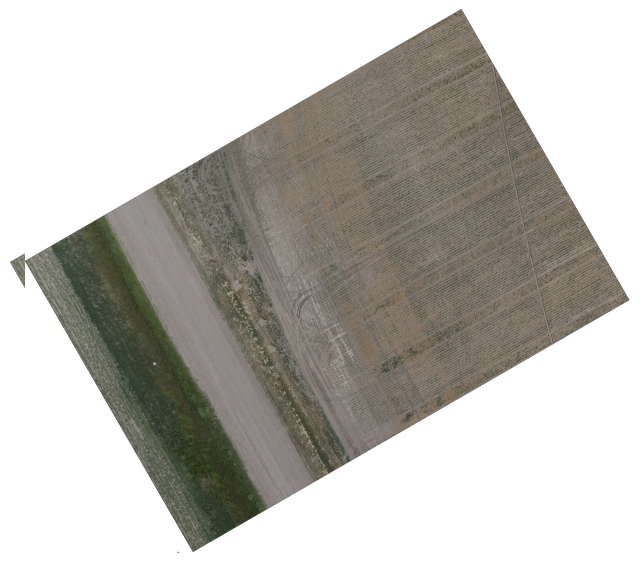

In [ ]:
display_tiff("/content/drive/MyDrive/DJI_DroneData/ImageWithBlackPart/stitched_output.tif")

In [ ]:
import cv2
import numpy as np
from osgeo import gdal

def read_tiff(image_path):
    dataset = gdal.Open(image_path)
    if dataset is None:
        raise ValueError(f"Could not open {image_path}")

    image = dataset.ReadAsArray()

    if len(image.shape) == 2:  # Grayscale to RGB
        image = np.stack([image] * 3, axis=-1)
    else:  # Transpose bands if needed
        image = np.transpose(image, (1, 2, 0))

    return image, dataset

def stitch_images(image1_path, image2_path, output_path):
    # Load both images
    img1, ds1 = read_tiff(image1_path)
    img2, ds2 = read_tiff(image2_path)

    # Convert to grayscale for feature detection
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors using ORB
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Match keypoints using FLANN
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        raise ValueError("Not enough keypoint matches found!")

    # Extract matched points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography matrix
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp the first image to align with the second
    height, width = img2.shape[:2]
    img1_aligned = cv2.warpPerspective(img1, H, (width, height))

    # Create masks for blending
    mask1 = (img1_aligned > 0).astype(np.uint8) * 255
    mask2 = (img2 > 0).astype(np.uint8) * 255
    combined_mask = cv2.bitwise_or(mask1, mask2)

    # Blend images smoothly
    stitched = np.where(mask1, img1_aligned, img2)

    # Save output as GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, width, height, 3, gdal.GDT_Byte)
    out_dataset.SetGeoTransform(ds2.GetGeoTransform())
    out_dataset.SetProjection(ds2.GetProjection())

    for i in range(3):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(stitched[:, :, i])

    out_dataset.FlushCache()
    print(f"Stitched image saved to {output_path}")

# Example Usage
stitch_images("/content/rotated_output90.tif", "/content/rotated_output91.tif", "stitched_output.tif")



error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:3399: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


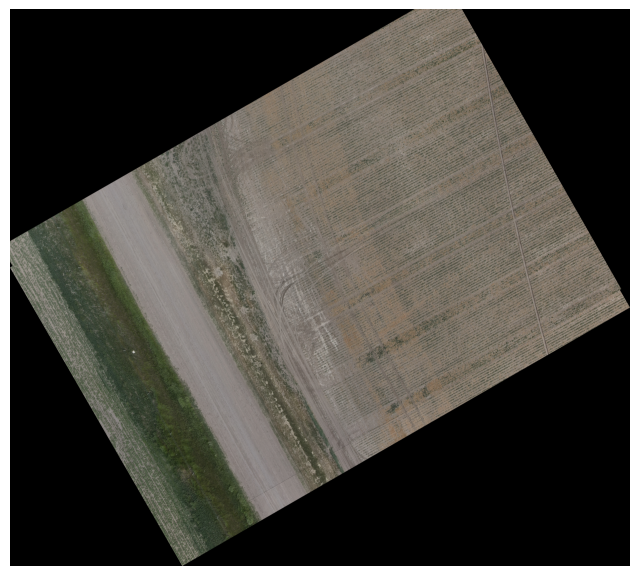

In [ ]:
display_tiff("stitched_output1.tif")

In [ ]:
import cv2
import numpy as np
from osgeo import gdal

def read_tiff(image_path):
    dataset = gdal.Open(image_path)
    if dataset is None:
        raise ValueError(f"Could not open {image_path}")

    image = dataset.ReadAsArray()

    if len(image.shape) == 2:  # Grayscale to RGB
        image = np.stack([image] * 3, axis=-1)
    else:  # Transpose bands if needed
        image = np.transpose(image, (1, 2, 0))

    return image, dataset

def stitch_images(image1_path, image2_path, output_path):
    # Load both images
    img1, ds1 = read_tiff(image1_path)
    img2, ds2 = read_tiff(image2_path)

    # Convert to grayscale for feature detection
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors using ORB
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Match keypoints using FLANN
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        print("⚠️ Not enough matches found. Placing images side by side.")
        # Handle non-overlapping case: Place images side by side
        stitched = np.zeros((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
        stitched[:img1.shape[0], :img1.shape[1]] = img1
        stitched[:img2.shape[0], img1.shape[1]:] = img2
    else:
        # Extract matched points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography matrix
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if H is None:
            print("⚠️ Homography could not be computed. Placing images side by side.")
            stitched = np.zeros((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
            stitched[:img1.shape[0], :img1.shape[1]] = img1
            stitched[:img2.shape[0], img1.shape[1]:] = img2
        else:
            # Warp the first image to align with the second
            height, width = img2.shape[:2]
            img1_aligned = cv2.warpPerspective(img1, H, (width, height))

            # Blend images
            mask1 = (img1_aligned > 0).astype(np.uint8) * 255
            mask2 = (img2 > 0).astype(np.uint8) * 255
            stitched = np.where(mask1, img1_aligned, img2)

    # Save output as GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(output_path, stitched.shape[1], stitched.shape[0], 3, gdal.GDT_Byte)
    out_dataset.SetGeoTransform(ds2.GetGeoTransform())
    out_dataset.SetProjection(ds2.GetProjection())

    for i in range(3):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(stitched[:, :, i])

    out_dataset.FlushCache()
    print(f"✅ Stitched image saved to {output_path}")

# Example Usage
stitch_images("/content/rotated_output90.tif", "/content/rotated_output91.tif", "stitched_output.tif")

✅ Stitched image saved to stitched_output.tif


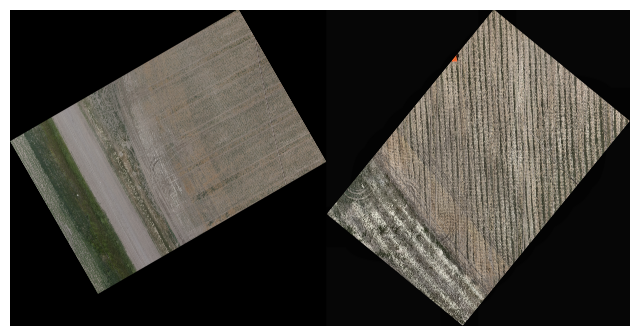

In [ ]:
display_tiff("stitched_output1.tif")

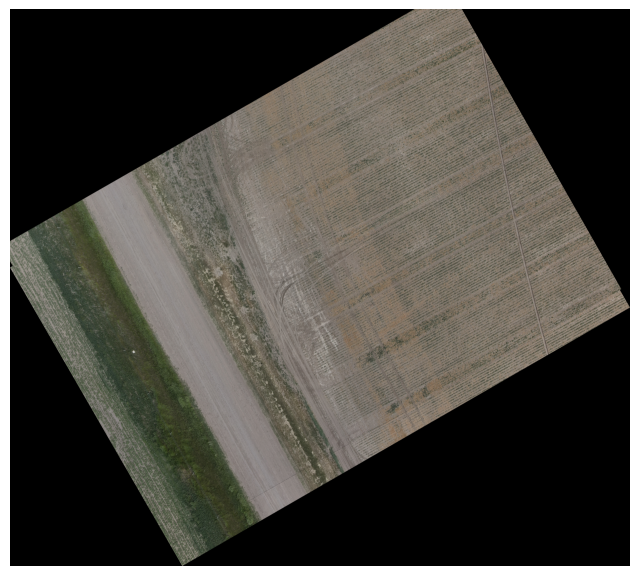

In [ ]:
display_tiff("stitched_output.tif")